In [2]:
import pandas as pd

In [8]:
raw_df=pd.read_csv('Advertising_Data.csv')

data  source: 

# Mixed Media Model Notebook

In this notebook, my hope is to showcase ongoing efforts to learn about Media Mixed Model methods as applied using PYMC and how they can be applied to real world cases. I have chosen to work with a data set taken from kaggel for this exercise.

## Description of Data
### Source
- [https://www.kaggle.com/datasets/singhnavjot2062001/product-advertising-data](https://www.kaggle.com/datasets/singhnavjot2062001/product-advertising-data)
### Media Variables
- Media spends on TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing and Affiliate_Marketing
### Target Variable
- Product_Sold: number of sales made by client in period
### Assumptions
- seaonality is does not exist
- currency type is irrelevant

## Exploring The Data

In [9]:
raw_df.head()

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
0,281.42,538.80,123.94,349.30,242.77,910.10,7164.0
1,702.97,296.53,558.13,180.55,781.06,132.43,5055.0
2,313.14,295.94,642.96,505.71,438.91,464.23,6154.0
3,898.52,61.27,548.73,240.93,278.96,432.27,5480.0
4,766.52,550.72,651.91,666.33,396.33,841.93,9669.0


In [10]:
raw_df.shape

(300, 7)

array([[<Axes: xlabel='TV', ylabel='TV'>,
        <Axes: xlabel='Billboards', ylabel='TV'>,
        <Axes: xlabel='Google_Ads', ylabel='TV'>,
        <Axes: xlabel='Social_Media', ylabel='TV'>,
        <Axes: xlabel='Influencer_Marketing', ylabel='TV'>,
        <Axes: xlabel='Affiliate_Marketing', ylabel='TV'>,
        <Axes: xlabel='Product_Sold', ylabel='TV'>],
       [<Axes: xlabel='TV', ylabel='Billboards'>,
        <Axes: xlabel='Billboards', ylabel='Billboards'>,
        <Axes: xlabel='Google_Ads', ylabel='Billboards'>,
        <Axes: xlabel='Social_Media', ylabel='Billboards'>,
        <Axes: xlabel='Influencer_Marketing', ylabel='Billboards'>,
        <Axes: xlabel='Affiliate_Marketing', ylabel='Billboards'>,
        <Axes: xlabel='Product_Sold', ylabel='Billboards'>],
       [<Axes: xlabel='TV', ylabel='Google_Ads'>,
        <Axes: xlabel='Billboards', ylabel='Google_Ads'>,
        <Axes: xlabel='Google_Ads', ylabel='Google_Ads'>,
        <Axes: xlabel='Social_Media', ylabel='

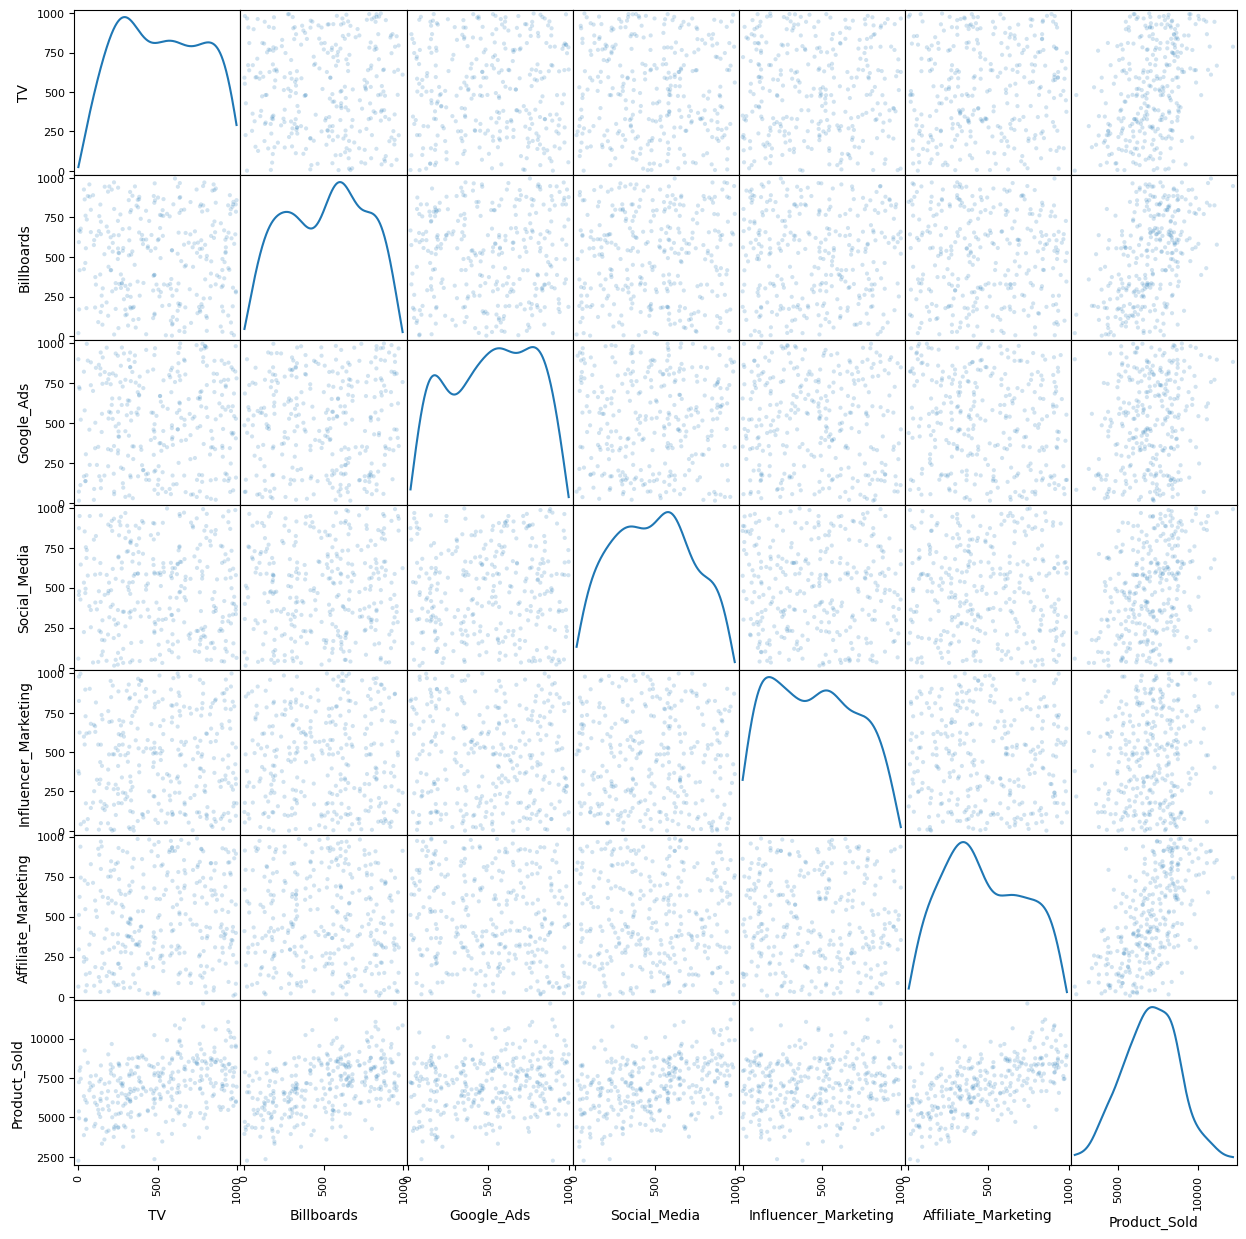

In [23]:
from pandas.plotting import scatter_matrix

scatter_matrix(raw_df, alpha=0.2, figsize=(15, 15), diagonal="kde")




<Axes: >

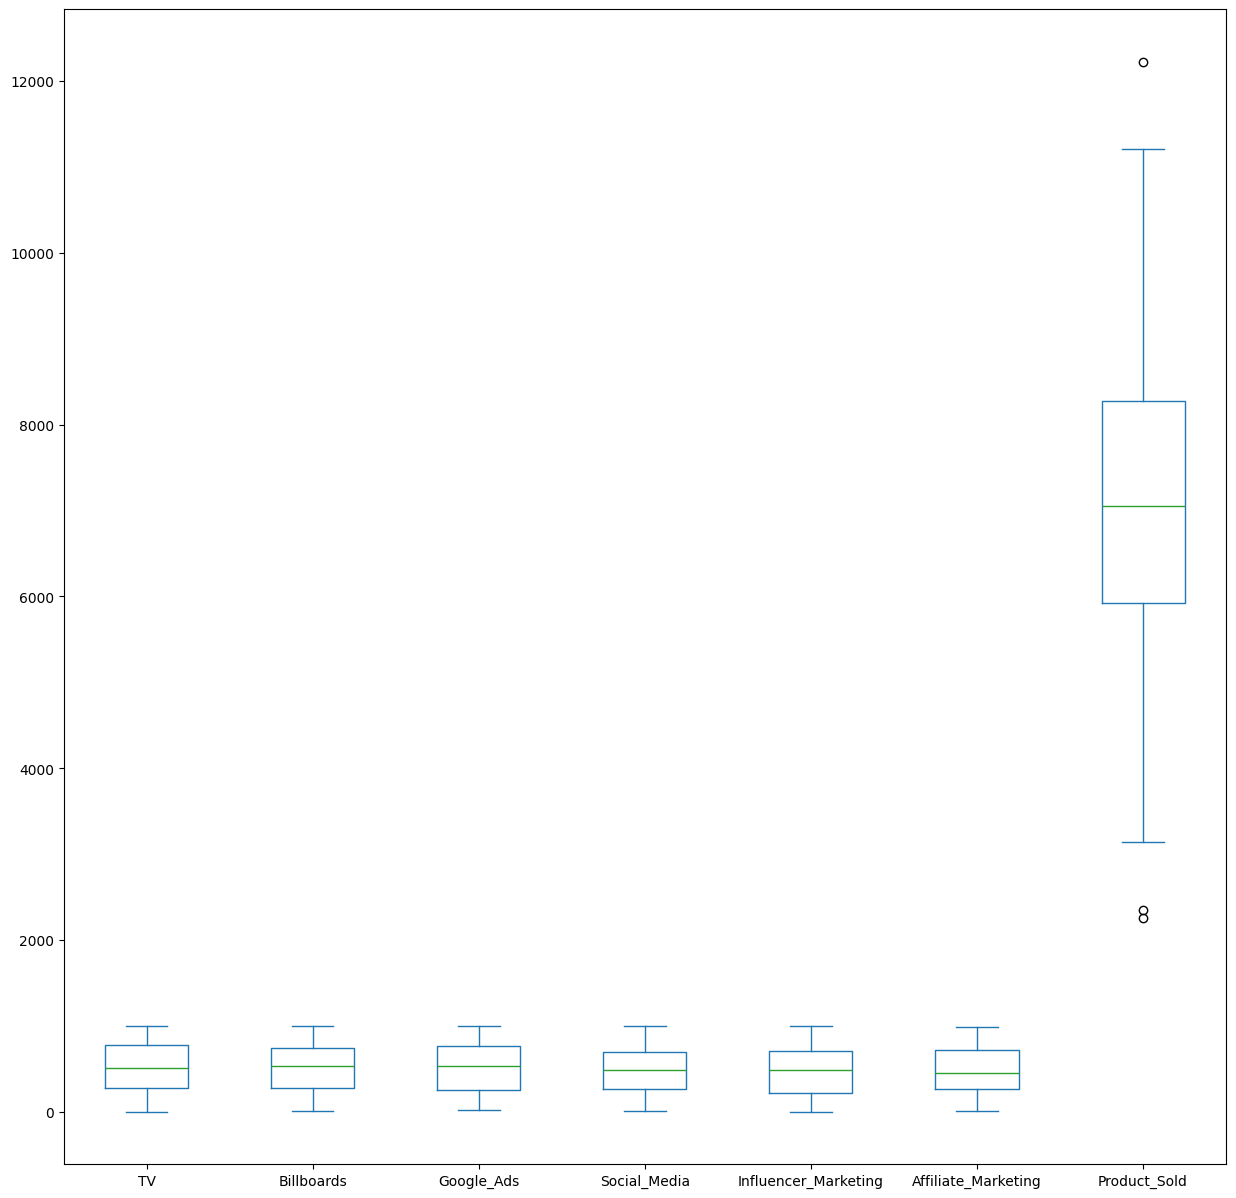

In [25]:
raw_df.plot.box(figsize=(15, 15))

In [37]:
Q1 = raw_df.Product_Sold.quantile(.25)
Q3 = raw_df.Product_Sold.quantile(.75)
IQR = Q3 - Q1

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Bottom Whisker: {Q1-IQR}")
print(f"Top Whisker: {Q3+IQR}")

Q1: 5922.5
Q3: 8278.0
IQR: 2355.5
Bottom Whisker: 3567.0
Top Whisker: 10633.5


In [35]:
ps_out = (raw_df.Product_Sold < Q1- IQR) | (raw_df.Product_Sold >Q3+IQR)
#raw_df.where(ps_out, raw_df)
raw_df[ps_out]

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
10,667.17,577.85,898.19,970.28,789.52,852.99,11210.0
11,787.33,947.73,884.15,992.30,871.55,742.36,12227.0
96,788.17,825.42,912.89,235.03,938.70,907.57,10763.0
99,283.57,358.42,213.66,29.11,622.68,90.42,3141.0
145,1.04,19.68,900.71,55.67,379.03,63.10,2259.0
176,149.78,191.97,558.87,172.98,412.79,178.45,3335.0
196,610.15,995.32,757.92,622.36,241.99,910.61,10841.0
259,529.95,191.30,89.94,28.84,507.41,256.91,3473.0
269,945.34,825.89,772.20,677.43,401.26,837.18,11062.0
281,480.67,135.75,82.66,217.72,217.90,15.41,2353.0


Looking at the outliers fro prodict sales, they do not appear to be so far out of line with the rest of the data as to be unreasonanble by my jugement so it is safe to continue.